#Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur ntende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.


In [1]:

from keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from keras.regularizers import l1, l2
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model

Lavoriamo da immagini ottenute a partire da MNIST.

In [2]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0

# Divido i dati in training e validation set
x_train, x_valid = train_test_split(x_train, test_size=0.2, random_state=42)

11490434/11490434 [==============================] - 0s 0us/step


Qui viene fornito il generatore che dovete utilizzare per il vostro progetto.
Non modificate in numero di mosse (10), nè il range della traslazione.

Siete liberi di modificare a piacimento la batchsize. Utilizzate x_train per il training e x_valid per la validazione.

In [3]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [ ]:
my_gen = generator(x_train,5)

In [4]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Qui potete vedere alcuni esempi restituiti dal generatore
Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


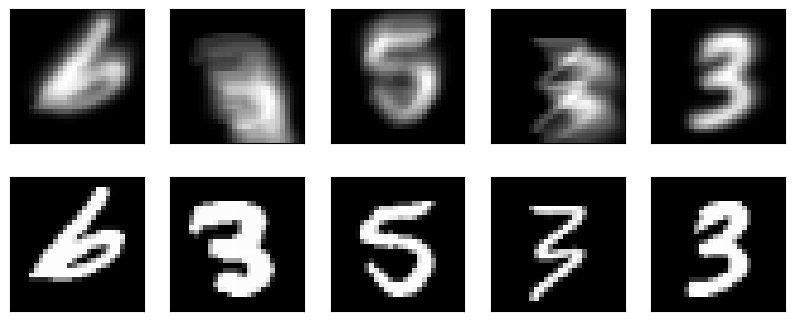

In [ ]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

In [ ]:
from google.colab import drive
mount_path = '/content/drive'
drive.mount(mount_path)
save_path = mount_path + '/MyDrive/modelsWeights'

Mounted at /content/drive


definizione del modello

In [7]:

# iperparametri
input_shape = (28, 28, 1)
batch_size = 128
kernel_size = 3
latent_dim = 64
layer_filters =  [32, 64]
dropout_rate = 0.2  # Tasso di dropout da 0.2 a 0.5
l2_reg = 0.001  # Coefficiente per la regolarizzazione L2
learning_rate = 0.0005
strides = 2

# Definizione dell'encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', padding='same',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')

# Definizione del decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', padding='same',
                        kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same', name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')


optimizer = Adam(learning_rate=learning_rate)

# Definizione dell'autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
autoencoder.summary()







Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 64)                219968    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         259905    
                                                                 
Total params: 479873 (1.83 MB)
Trainable params: 479489 (1.83 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


fase di training

In [8]:
LOAD_WEIGHTS = False

if LOAD_WEIGHTS:
  autoencoder.load_weights(save_path + '/pesi_autoencoder.h5')

history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=batch_size, validation_data=(x_valid, x_valid))



Epoch 1/100
375/375 [==============================] - 15s 17ms/step - loss: 0.0835 - accuracy: 0.7857 - val_loss: 0.0961 - val_accuracy: 0.8090
Epoch 2/100
375/375 [==============================] - 5s 12ms/step - loss: 0.0089 - accuracy: 0.8148 - val_loss: 0.0169 - val_accuracy: 0.8147
Epoch 3/100
375/375 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.8150 - val_loss: 0.0042 - val_accuracy: 0.8155
Epoch 4/100
375/375 [==============================] - 5s 13ms/step - loss: 0.0059 - accuracy: 0.8151 - val_loss: 0.0038 - val_accuracy: 0.8156
Epoch 5/100
375/375 [==============================] - 5s 12ms/step - loss: 0.0054 - accuracy: 0.8152 - val_loss: 0.0036 - val_accuracy: 0.8156
Epoch 6/100
375/375 [==============================] - 5s 13ms/step - loss: 0.0052 - accuracy: 0.8152 - val_loss: 0.0035 - val_accuracy: 0.8156
Epoch 7/100
375/375 [==============================] - 5s 14ms/step - loss: 0.0050 - accuracy: 0.8152 - val_loss: 0.0035 - val_accuracy

plotto i grafici della history

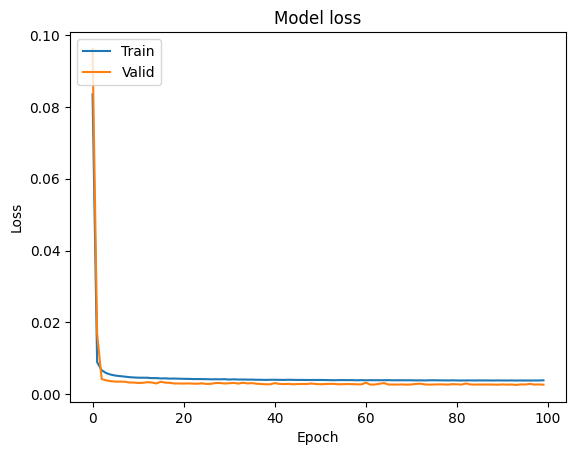

In [9]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

salvo i pesi della rete

In [ ]:
autoencoder.save_weights(save_path + '/pesi_autoencoder.h5')


# Valutazione

Utilizzate Mean Squared Error (mse) per valutare l'errore tra l'immagine deblurred e la ground truth.

Misurate l' mse su 10000 immagini blurred ottenute dal validation set.

Ripetete la computazione precedente per 10 volte, e fornite come risutato la
**media dei 10 round, unitamente alla deviazione standard**.


In [15]:
mse = MeanSquaredError()

mse_values = []

for _ in range(10):
    
    blurred_images, ground_truth_images = next(generator(x_valid.squeeze(), 10000))
   
    deblurred_images = autoencoder.predict(blurred_images).squeeze()
   
    error = mse(ground_truth_images, deblurred_images)

    
    mse_values.append(error)

# Calcola la media e la deviazione standard dei valori MSE
mse_mean = np.mean(mse_values)
mse_std = np.std(mse_values)

print(f'MSE Mean: {mse_mean}, MSE Std: {mse_std}')


313/313 [==============================] - 1s 2ms/step
MSE Mean: 0.05368370935320854, MSE Std: 0.00026758076273836195


di seguito faccio vedere dei plot di mie predizioni del modello confrontate con la corrispondente ground truth e immagini con blur

1/1 [==============================] - 0s 172ms/step
10


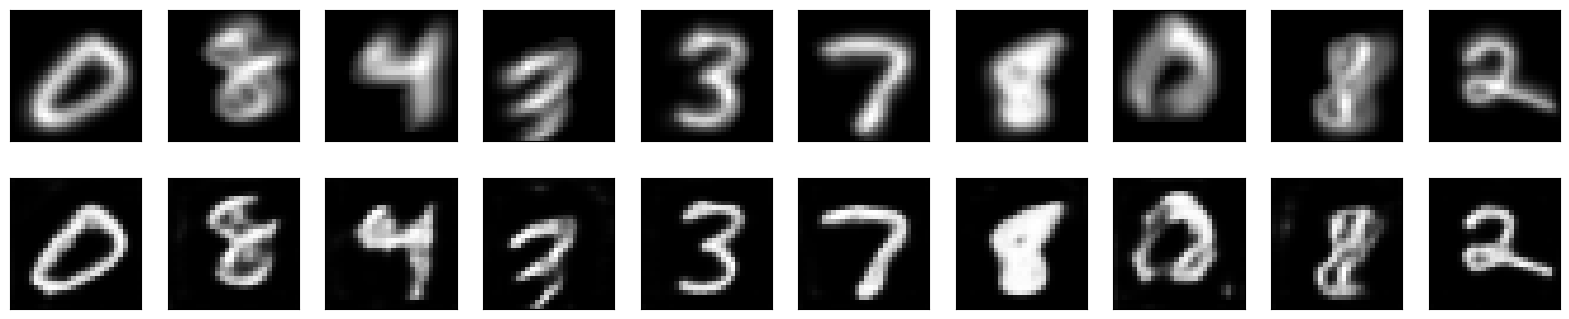

10


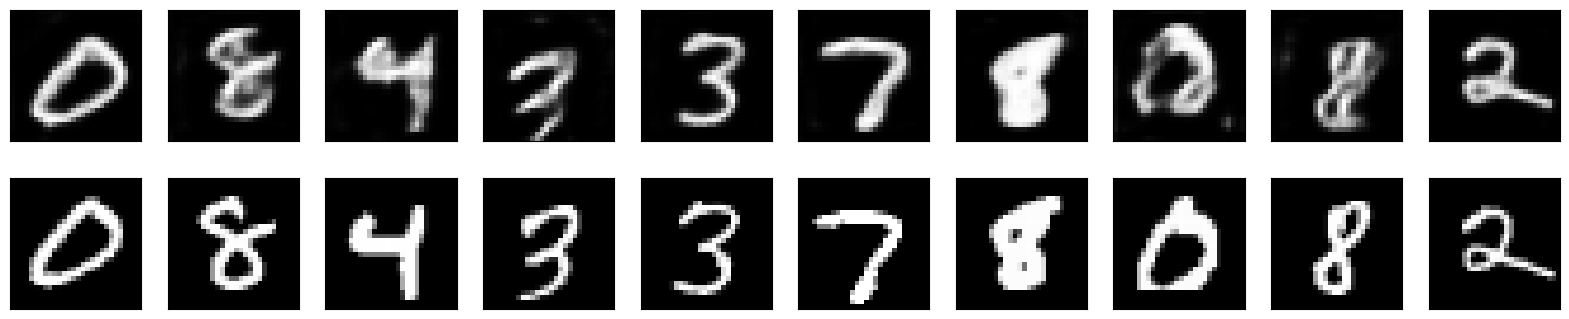

In [11]:
blurred_images, ground_truth_images = next(generator(x_valid.squeeze(), 10))
deblurred_images = autoencoder.predict(blurred_images).squeeze()
plot(blurred_images, deblurred_images)
plot(deblurred_images, ground_truth_images)

# Cosa consegnare
Il lavoro deve essere scolto in keras/tensorflow. Consegnate un singolo notebook dove dovete conservare traccia del training.

Discutete e motivate l'architettura finale, cosi come la scelta dei principali iperparametri.

#architettura finale
Nel progetto di deblurring di immagini, ho optato per l'impiego di un autoencoder, infatti questo modello é idoneo a questo compito poiché impara a codificare caratteristiche importanti nello spazio latente e a ricostruire l'output da questa rappresentazione codificata. È una scelta comune per compiti di ricostruzione delle immagini, inclusi il denoising e il deblurring.
I vari layer convoluzionali sono stati efficaci nel catturare gerarchie spaziali e pattern nelle immagini.
I layer densi invece sono stati responsabili della compressione e decompressione dei dati, permettendo all' autoencoder di apprendere rappresentazioni efficienti dei dati.
Nei compiti di deblurring, aiutano il modello a comprendere e ricostruire i dettagli fini dell'immagine.
Inizialmente, l'autoencoder era composto esclusivamente da layer convoluzionali e densi, ma i risultati non erano ottimali. Di conseguenza, ho apportato delle modifiche, integrando layer di Batch Normalization e Dropout, oltre a regolarizzatori l2. La Batch Normalization standardizza gli input di ogni strato, contribuendo a un processo di allenamento più stabile e veloce. Il Dropout, disattivando casualmente una frazione di neuroni, riduce la dipendenza del modello da specifici neuroni, mitigando il rischio di overfitting. I regolarizzatori l1 e l2 sono stati implementati per penalizzare i pesi eccessivamente grandi, ulteriormente prevenendo l'overfitting.
#iperparametri
Riguardo gli iperparametri, ho utilizzato valori standard per batch size, dropout_rate e l2_reg. Per la dimensione dello spazio latente, ho optato per un valore di 64. Ho constatato che incrementare ulteriormente questa dimensione rendeva la rete eccessivamente complessa per l'applicazione in questione. Per il learning rate, ho scelto un valore di 0.0005, leggermente inferiore allo standard di 0.001, dopo aver osservato miglioramenti nelle prestazioni del modello.

Giuseppe Spathis 0001043077